<a href="https://colab.research.google.com/github/TheegalaAkshaya/Coffee-Bean-Quality-Prediction/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow numpy matplotlib opencv-python scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, color, segmentation, filters, metrics
import matplotlib.pyplot as plt
%matplotlib inline
import os
import skimage as sk
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Normalization, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from os import listdir
from os.path import isfile, join
import glob
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121

In [ ]:
base_dir = '/content/drive/MyDrive/Project'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


**data preprocessing**

Found 1194 images belonging to 4 classes.
Found 405 images belonging to 4 classes.
Class Indices:
{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

Class Names:
{0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}


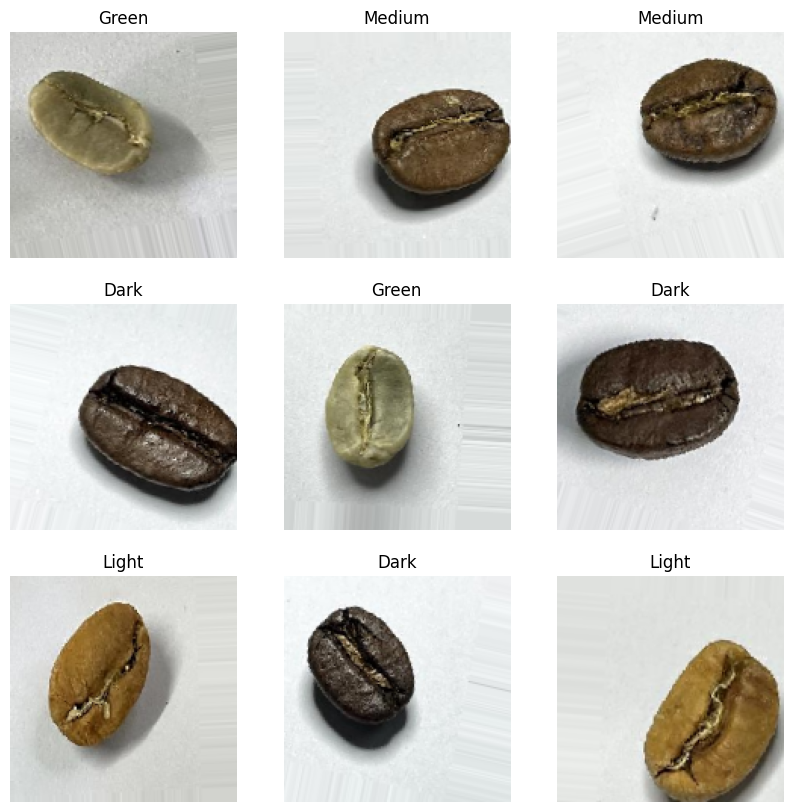

In [ ]:
# Create an ImageDataGenerator for training data with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Create an ImageDataGenerator for test data (usually without augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Get class indices from the training generator
class_indices = train_generator.class_indices

# Invert the dictionary for easier lookup of class names from indices
class_names = {v: k for k, v in class_indices.items()}

# Print class indices and names
print("Class Indices:")
print(class_indices)
print("\nClass Names:")
print(class_names)


# Function to plot images with class labels
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Example usage: Plot a few images from the training set
images, labels = next(train_generator)
plot_images(images, np.argmax(labels, axis=1), class_names)

**DATA AUGMENTATION**

 rotations, flips, zooms

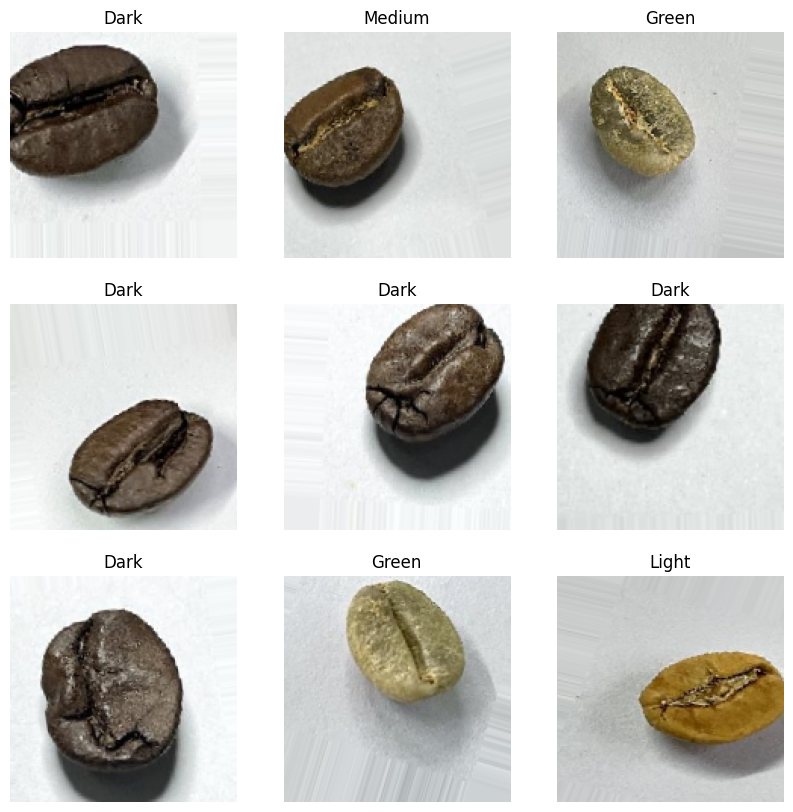

In [ ]:
# Get a batch of augmented images and labels
images, labels = next(train_generator)

# Function to plot augmented images with class labels
def plot_augmented_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot the first 9 augmented images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])  # Get the class name from the one-hot encoded labels
        plt.axis("off")
    plt.show()

# Plot augmented images
plot_augmented_images(images, labels, class_names)

**load pretrained denseNet model**

In [ ]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
predictions = Dense(len(class_names), activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (optional, but often recommended)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 38, 38, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 38, 38, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 38, 38, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Train the model**

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs as needed
    validation_data=test_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)] # Stop training if validation loss doesn't improve
)
# Save the model
model.save('/content/drive/MyDrive/Project/my_model.h5') # Save the model to your Google Drive
print("Model saved successfully")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 332s 8s/step - accuracy: 0.6203 - loss: 1.3157 - val_accuracy: 0.9333 - val_loss: 0.1741
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9455 - loss: 0.1496 - val_accuracy: 0.9407 - val_loss: 0.1582
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9698 - loss: 0.0823 - val_accuracy: 0.9802 - val_loss: 0.0605
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9736 - loss: 0.0700 - val_accuracy: 0.9827 - val_loss: 0.0534
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9739 - loss: 0.0713 - val_accuracy: 0.9704 - val_loss: 0.0642
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9664 - loss: 0.1092 - val_accuracy: 0.9333 - val_loss: 0.1864
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9386 - loss: 0.1962 - val_accuracy: 0.9778 - val_loss: 0.0764


Model saved successfully


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9828 - loss: 0.0535
Test Accuracy: 0.9778


In [ ]:
# Get true labels and predicted labels for the test set
from sklearn.metrics import classification_report, confusion_matrix # Import necessary functions

test_generator.reset()  # Reset the generator to avoid random shuffling
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Get predicted class labels (instead of binary classes)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the highest probability for each sample


# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:\n', cm)

# Classification report
target_names = ['Dark', 'Green', 'Light', 'Medium']
print('Classification Report:\n', classification_report(y_true, y_pred_classes, target_names=target_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Confusion Matrix:
 [[22 26 25 32]
 [27 27 19 27]
 [26 19 30 25]
 [23 28 24 25]]
Classification Report:
               precision    recall  f1-score   support

        Dark       0.22      0.21      0.22       105
       Green       0.27      0.27      0.27       100
       Light       0.31      0.30      0.30       100
      Medium       0.23      0.25      0.24       100

    accuracy                           0.26       405
   macro avg       0.26      0.26      0.26       405
weighted avg       0.26      0.26      0.26       405



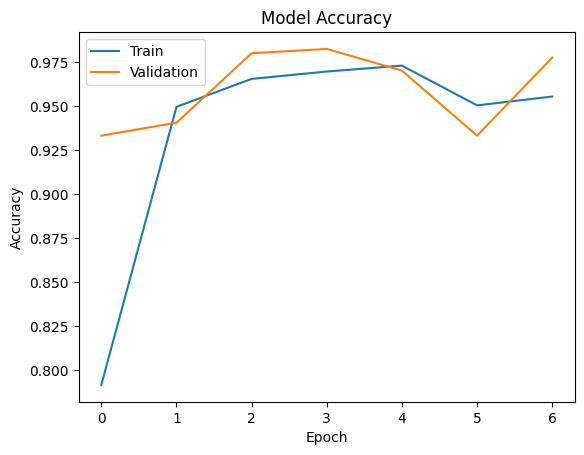

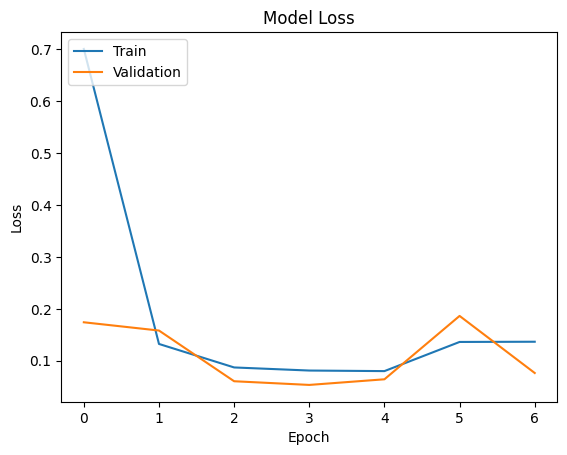

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the final model
model.save('bean_classifier.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The bean in the image is classified as: Dark


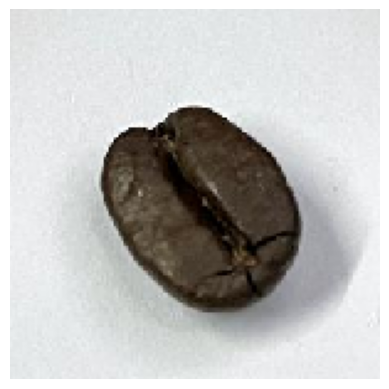

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model, use the correct model name 'bean_classifier.h5'
model = load_model('bean_classifier.h5')

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to match training size
    img_array = image.img_to_array(img) / 255.0             # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension
    return img_array

# Function to predict the class of the bean image
def predict_bean_image(img_path):
    img_array = preprocess_image(img_path)  # Preprocess the image
    prediction = model.predict(img_array)   # Get the prediction probability

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the class names from the model (if available)
    class_names = ['Dark', 'Green', 'Light', 'Medium'] # Replace with actual class names if different

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Function to display the image
def display_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Load and resize the image
    plt.imshow(img)                                         # Display the image
    plt.axis('off')                                        # Turn off axis labels
    plt.show()

# Path to the bean image to test
image_path = '/content/drive/MyDrive/Project/test/Dark/Dark_0.jpg'  # Replace with the path to your test image

# Predict and print the result
result = predict_bean_image(image_path)
print(f'The bean in the image is classified as: {result}')

# Display the image
display_image(image_path)

Found 405 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9769 - loss: 0.7594
Validation Loss: 0.7308692932128906
Validation Accuracy: 0.9777777791023254
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Result: Dark


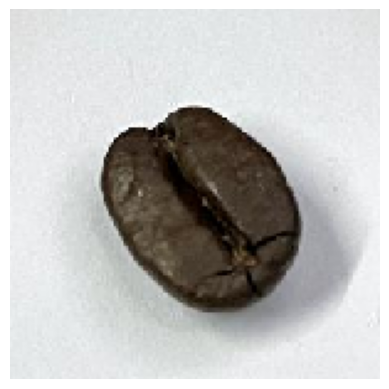

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('bean_classifier.h5')

# Compile the model to ensure metrics are built
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare the validation data generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Project/test',  # Your validation data directory
    target_size=(150, 150),  # Change target_size to (150, 150)
    batch_size=32,
    class_mode='categorical' # Change class_mode to 'categorical'
)
# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

# Function to preprocess the image
def preprocess_image(img_path):
    """
    Preprocesses the image by resizing and normalizing it.

    Args:
        img_path (str): The path to the image file.

    Returns:
        numpy.ndarray: The preprocessed image as a NumPy array.
    """
    img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to (150, 150)
    img_array = image.img_to_array(img) / 255.0             # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension
    return img_array

# Function to predict the class of the bean image
def predict_bean_image(img_path):
    """
    Predicts the class of the bean image.

    Args:
        img_path (str): The path to the image file.

    Returns:
        str: The predicted class name.
    """
    img_array = preprocess_image(img_path)  # Preprocess the image
    prediction = model.predict(img_array)   # Get the prediction probability

    # Get the predicted class index (assuming multi-class classification)
    predicted_class_index = np.argmax(prediction)

    # Get the class names from the model (if available)
    class_names = ['Dark', 'Green', 'Light', 'Medium'] # Replace with actual class names if different

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name


# Function to display the image
def display_image(img_path):
    """
    Displays the image.

    Args:
        img_path (str): The path to the image file.
    """
    img = image.load_img(img_path, target_size=(150, 150))  # Load and resize the image to (150, 150)
    plt.imshow(img)                                         # Display the image
    plt.axis('off')                                        # Turn off axis labels
    plt.show()

# Path to the bean image to test
image_path = '/content/drive/MyDrive/Project/test/Dark/Dark_0.jpg'  # Replace with the path to your test image

# Predict and print the result
result = predict_bean_image(image_path)
print(f'Result: {result}')

# Display the image
display_image(image_path)

In [ ]:
model.save('/content/major.h5')  # Save the trained model as 'major.h5'